# KC  CABIN UPGRADE conversion

In [2]:
!pip install ipython-sql

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
#!pip install -U numpy

In [4]:
#!python --version

In [5]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [6]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [15]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [16]:
query="""
SELECT * FROM ml_prep.gauthier_offer_load_all_kc_2019_2020_dataset ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


event_time                          request_id  partner_id  \
0  2019-06-03T04:25:19Z  c3iP33SpbqzKlFNpqEDgBd9QY3z7A0x8Wq         387   
1  2019-06-03T04:25:19Z  c3iP33SpbqzKlFNpqEDgBd9QY3z7A0x8Wq         387   
2  2019-07-23T19:56:14Z  lFge8sifbIQeI9YdyRYfP7szkFGF7Ctpln         387   

  origin destination  flight_number departure_date departure_time from_cabin  \
0    TSE         URA            979     2019-06-06          06:55    ECONOMY   
1    ALA         TSE            855     2019-06-05          21:00    ECONOMY   
2    FRA         TSE            922     2019-07-27          19:55    ECONOMY   

  upgrade_type  ... last_email_opened_time  email_opened_count  \
0     BUSINESS  ...    2019-06-02 08:39:32                   9   
1     BUSINESS  ...    2019-06-02 08:39:32                   9   
2     BUSINESS  ...    2019-07-27 01:49:07                  13   

  first_email_clicked_time last_email_clicked_time email_clicked_count  \
0                     None                    None                   0   
1                     None                    None                   0   
2                     None                    None                   0   

   offer_amount_usd  offer_amount_total_usd offer_quantity offer_customer_id  \
0               NaN                     NaN           None              None   
1               NaN                     NaN           None              None   
2               NaN                     NaN           None              None   

  offer_type  
0     NO_BID  
1     NO_BID  
2     NO_BID  

[3 rows x 50 columns]

# Feature Engineering

In [19]:
#drop non relevant fields
df = df.drop(['distance_unit', 'request_id', 'slider_min','slider_max', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', 'instant_upgrade_eligibility','slider_step'
        ], axis=1)



In [20]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_date']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_date']).apply(lambda x: x.month)
df['event_day_of_week']= pd.to_datetime(df['event_time']).apply(lambda x: x.dayofweek)
df['event_hour']= pd.to_datetime(df['event_time']).apply(lambda x: x.hour)
df['event_month']= pd.to_datetime(df['event_time']).apply(lambda x: x.month)
df['event_year']= pd.to_datetime(df['event_time']).apply(lambda x: x.year)


df['origin_destination'] = df['origin']+ df['destination']
df["days_before_departure"] =(pd.to_datetime(df["departure_date"])-pd.to_datetime(df["event_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["event_time"]) - pd.to_datetime(df["first_offer_load_time"])).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [21]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-06-03T04:25:19Z         387    TSE         URA            979   
1  2019-06-03T04:25:19Z         387    ALA         TSE            855   
2  2019-07-23T19:56:14Z         387    FRA         TSE            922   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-06-06          06:55    ECONOMY     BUSINESS  2019-06-02T06:38:15Z   
1     2019-06-05          21:00    ECONOMY     BUSINESS  2019-06-02T06:38:15Z   
2     2019-07-27          19:55    ECONOMY     BUSINESS  2019-07-23T19:56:14Z   

   ...  last_email_opened_days_before_departure days_since_first_email_opened  \
0  ...                                        3                            54   
1  ...                                        2                            54   
2  ...                                       -1                            66   

  days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                            0                                          0   
1                            0                                          0   
2                           -4                                          0   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                         0                              0   
1                                         0                              0   
2                                         0                              0   

  days_since_last_email_clicked days_between_first_last_email_sent  \
0                             0                                 54   
1                             0                                 54   
2                             0                                 67   

  days_between_first_last_email_opened  days_between_first_last_email_clicked  
0                                   53                                      0  
1                                   53                                      0  
2                                   69                                      0  

[3 rows x 67 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189629 entries, 0 to 189628
Data columns (total 67 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   event_time                                 189629 non-null  object        
 1   partner_id                                 189629 non-null  int64         
 2   origin                                     189629 non-null  object        
 3   destination                                189629 non-null  object        
 4   flight_number                              189629 non-null  int64         
 5   departure_date                             189629 non-null  object        
 6   departure_time                             189629 non-null  object        
 7   from_cabin                                 189629 non-null  object        
 8   upgrade_type                               189629 non-null  object        
 9   firs

# Feature Encoding

In [23]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [24]:
# label-encode categories
df= label_encode_categorical(df,['origin','channel_source','destination','origin_destination','language','point_of_sale','equipment'])

label encoding origin ...
label encoding channel_source ...
label encoding destination ...
label encoding origin_destination ...
label encoding language ...
label encoding point_of_sale ...
label encoding equipment ...


# Label encode

In [25]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_type'])
df['offer_type_encoded'] = label_encoder.transform(df['offer_type'])

In [26]:
label_encoder.classes_

array(['BUSINESS', 'NO_BID', 'PREMIUM_ECONOMY'], dtype=object)

In [27]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-06-03T04:25:19Z         387    TSE         URA            979   
1  2019-06-03T04:25:19Z         387    ALA         TSE            855   
2  2019-07-23T19:56:14Z         387    FRA         TSE            922   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-06-06          06:55    ECONOMY     BUSINESS  2019-06-02T06:38:15Z   
1     2019-06-05          21:00    ECONOMY     BUSINESS  2019-06-02T06:38:15Z   
2     2019-07-27          19:55    ECONOMY     BUSINESS  2019-07-23T19:56:14Z   

   ...  days_between_first_last_email_opened  \
0  ...                                    53   
1  ...                                    53   
2  ...                                    69   

  days_between_first_last_email_clicked origin_encoded  \
0                                     0             35   
1                                     0              1   
2                                     0             11   

   channel_source_encoded  destination_encoded origin_destination_encoded  \
0                       1                   37                        115   
1                       1                   35                         25   
2                       1                   35                         42   

  language_encoded point_of_sale_encoded equipment_encoded  offer_type_encoded  
0               14                     0                 6                   1  
1               14                     0                 1                   1  
2               14                     1                 4                   1  

[3 rows x 75 columns]

In [28]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'event_hour',
                       'event_day_of_week',
                       'event_year',
                       'event_month',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'destination_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       'distance', 
                       # the rest
                       'channel_source_encoded',
                       'language_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       # slider
                       'slider_max_usd',        
                       'slider_min_usd',        
                       'slider_start_usd',  
                       # previous offer loads
                        'offer_load_count',
                        'days_since_first_offer_load',
                        'first_offer_load_days_before_departure',
                       # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_type_encoded',
                      ]

df = df[columns_for_training]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189629 entries, 0 to 189628
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   departure_hour                             189629 non-null  int64  
 1   departure_day_of_week                      189629 non-null  int64  
 2   departure_month                            189629 non-null  int64  
 3   event_hour                                 189629 non-null  int64  
 4   event_day_of_week                          189629 non-null  int64  
 5   event_year                                 189629 non-null  int64  
 6   event_month                                189629 non-null  int64  
 7   days_before_departure                      189629 non-null  int64  
 8   origin_encoded                             189629 non-null  int64  
 9   destination_encoded                        189629 non-null  int64  
 10  origin_d

In [30]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  event_hour  \
0               6                      3                6           4   
1              21                      2                6           4   
2              19                      5                7          19   
3              19                      5                6          13   

   event_day_of_week  event_year  event_month  days_before_departure  \
0                  0        2019            6                      2   
1                  0        2019            6                      1   
2                  1        2019            7                      3   
3                  3        2019            6                      8   

   origin_encoded  destination_encoded  ...  \
0              35                   37  ...   
1               1                   35  ...   
2              11                   35  ...   
3               1                   31  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         0                               0   
2                                         0                               0   
3                                         0                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                  54   
1                              0                                  54   
2                              0                                  67   
3                              0                                  24   

   days_between_first_last_email_opened  \
0                                    53   
1                                    53   
2                                    69   
3                                     8   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 8   
1                                      0                 8   
2                                      0                 6   
3                                      0                 6   

   email_opened_count  email_clicked_count  offer_type_encoded  
0                   9                    0                   1  
1                   9                    0                   1  
2                  13                    0                   1  
3                  14                    0                   1  

[4 rows x 43 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22f64d9908>]],
      dtype=object)

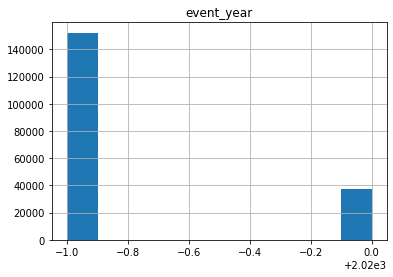

In [31]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='event_year')

# Model Training & Evaluation

In [32]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [39]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_type_encoded", axis=1)
    y_raw = df_to_train["offer_type_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["event_year"] == 2019 ].drop("event_year", axis=1)
        y_train = y[X["event_year"] == 2019]
        X_test = X[X["event_year"] == 2020].drop("event_year", axis=1)
        y_test = y[X["event_year"] == 2020]
        print('split on time')
    else:
        X = X.drop("event_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        print('# KC offer type prediction. Feature importance for',label_encoder.classes_[i])
        for feature,importance in zip(features[indices],importances[indices]):
            print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('# KC offer type prediction. Feature importance for ' + str(label_encoder.classes_[i]))
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)


In [ ]:
train_and_evaluate(df,plot_learning_curves=False,limit=100000)

split on time
training on 152187 rows...
training is done!
testing on 37442 rows...
global roc_auc 0.883849099529932
#### CLASS BUSINESS ####
precision 0.6304347826086957
recall 0.031049250535331904
f1 0.05918367346938775
support 934
#### CLASS NO_BID ####
precision 0.975524943159021
recall 0.9993423576478325
f1 0.9872900282895004
support 36494
#### CLASS PREMIUM_ECONOMY ####
precision 0.0
recall 0.0
f1 0.0
support 14
# KC offer type prediction. Feature importance for BUSINESS
offer_load_count,0.06944794438091027
event_hour,0.06103243555921338
slider_max_usd,0.06087742259265513
slider_start_usd,0.05997586338794608
slider_min_usd,0.05864271337925539
days_before_departure,0.046400267630832666
first_offer_load_days_before_departure,0.04607547624043079
event_day_of_week,0.03746977598977068
language_encoded,0.035900443253783984
distance,0.03565739163327279
duration,0.03488928795367598
departure_day_of_week,0.03355753733916992
channel_source_encoded,0.03352715238750452
departure_hour,0.03302

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KC offer type prediction. Feature importance for NO_BID
offer_load_count,0.06852829002486366
event_hour,0.06151022165910922
slider_start_usd,0.05974361210169625
slider_max_usd,0.0594721062986306
slider_min_usd,0.057035402359298264
days_before_departure,0.047348268917947696
first_offer_load_days_before_departure,0.046810590882816465
event_day_of_week,0.037167508561134405
distance,0.035638940981250096
language_encoded,0.03499290370808637
duration,0.03491501636902595
departure_day_of_week,0.034200278139462525
channel_source_encoded,0.03389619594157787
departure_month,0.032858499446907004
departure_hour,0.032719427438392
event_month,0.031873112925839865
origin_destination_encoded,0.028134235749800836
equipment_encoded,0.020069793573267092
destination_encoded,0.019512023728551462
email_sent_count,0.01894733969844807
email_opened_count,0.018582959178143135
origin_encoded,0.018396021224479066
days_since_last_email_sent,0.01731543555252508
last_email_sent_days_before_departure,0.016350657487

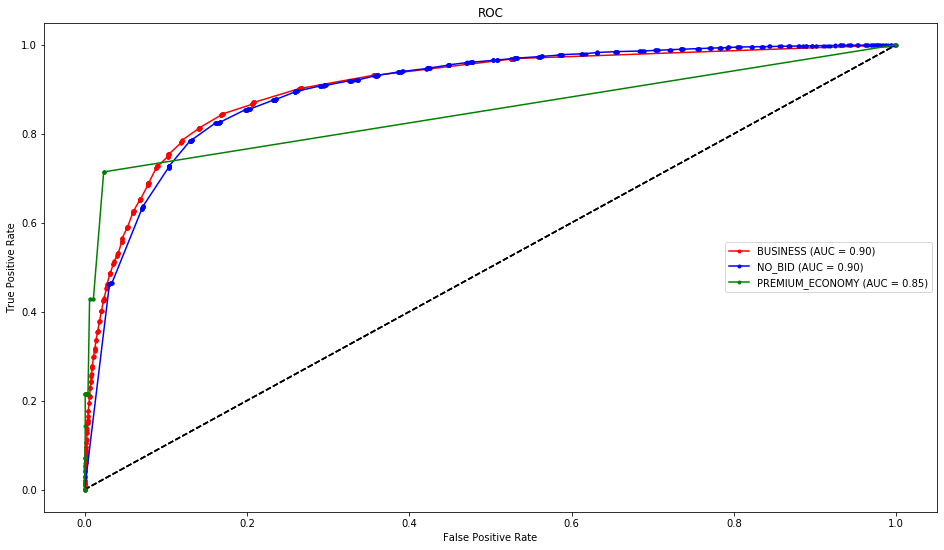

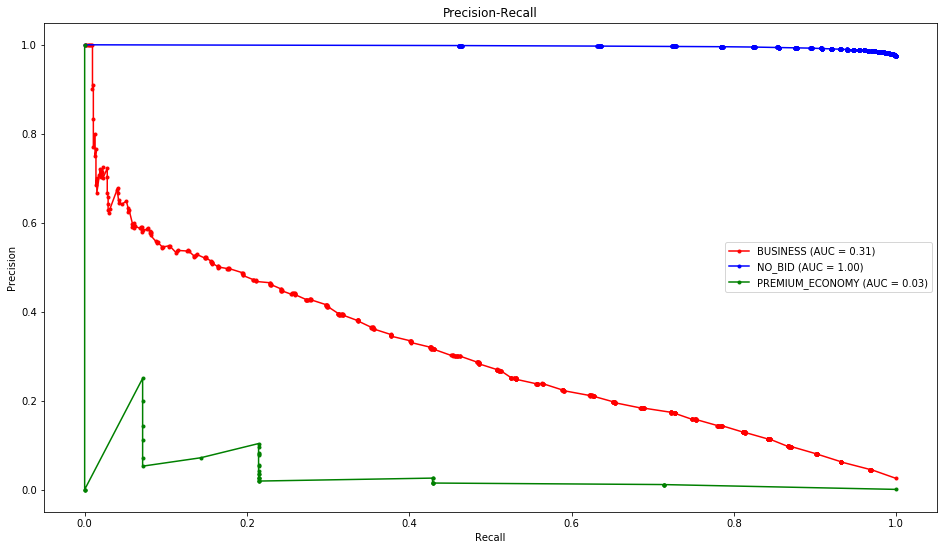

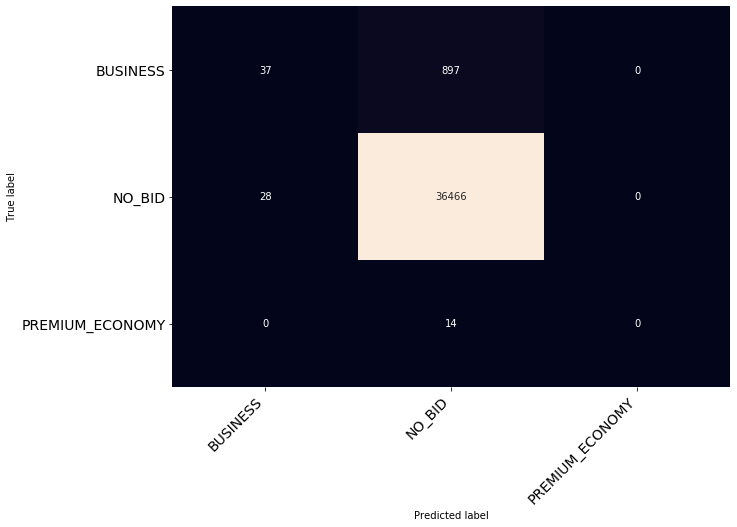

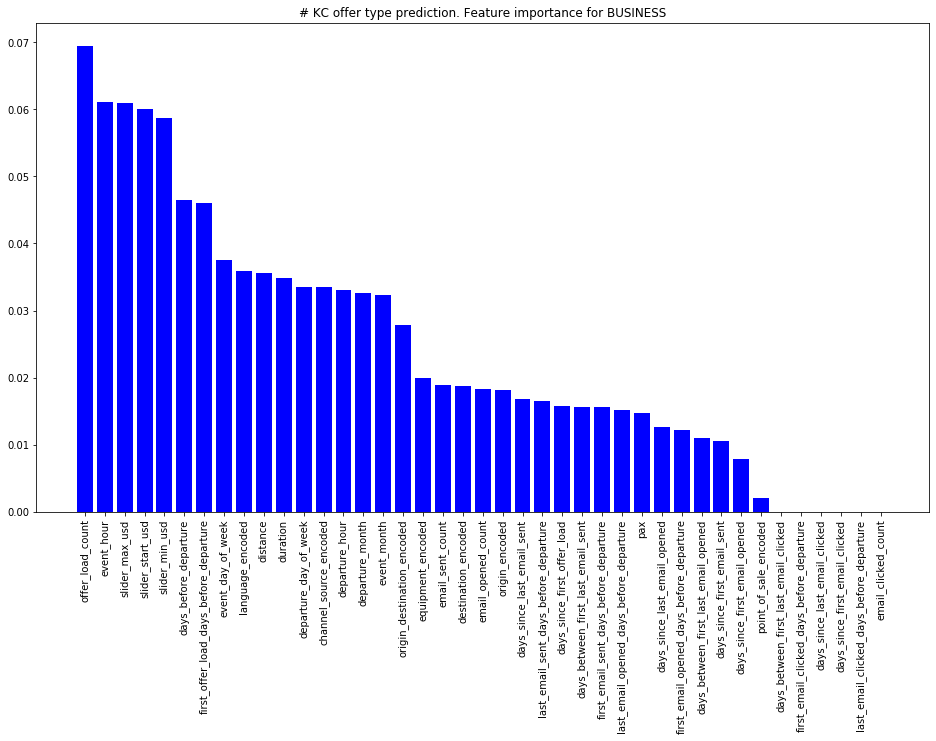

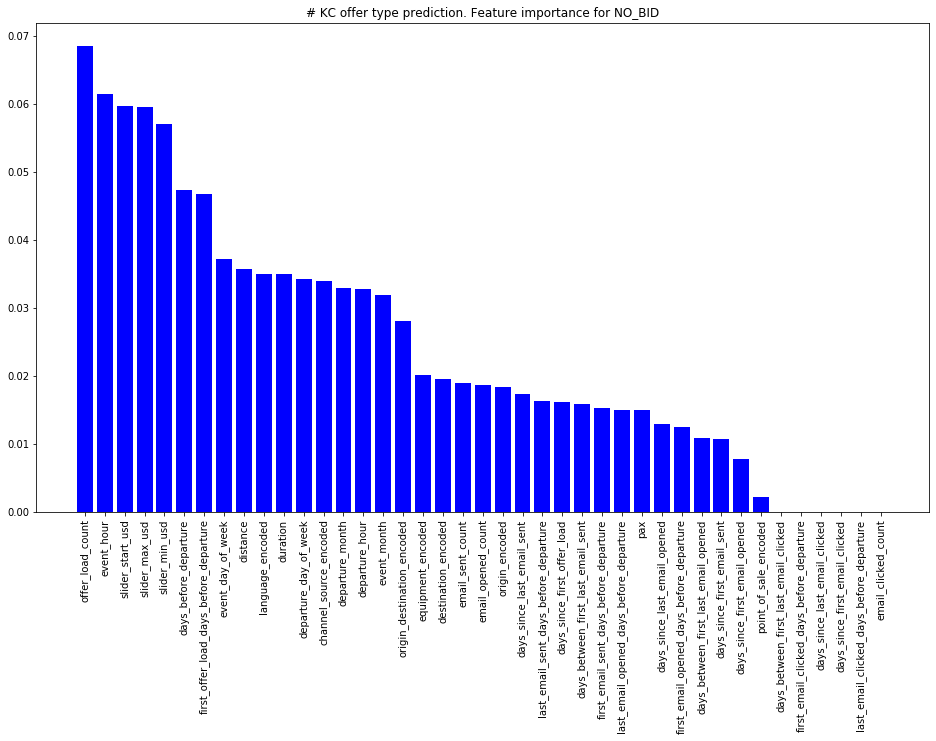

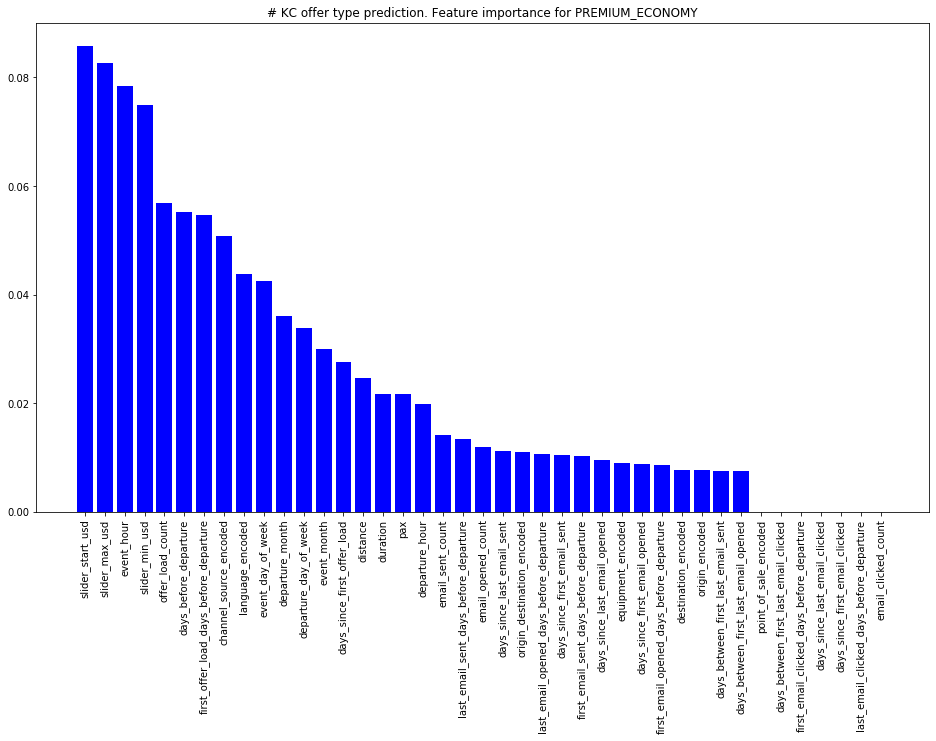

In [40]:
train_and_evaluate(df,plot_learning_curves=False,limit=None, split_on_time=True)